In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
from scipy.stats import gamma
from scipy.stats import skew, kurtosis, shapiro, kstest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [29]:
dataset= pd.read_csv('insurance.csv', sep=',', encoding='ISO-8859-1')
dataset

df = pd.DataFrame(dataset)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## FEATURE ENGINEERING

In [31]:
# Copy dataset asli
df_new = df.copy()

# Mapping smoker: yes -> 1, no -> 0
df_new['smoker'] = df_new['smoker'].map({'yes': 1, 'no': 0})

# Cek hasil
df_new


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,0,northwest,10600.54830
1334,18,female,31.920,0,0,northeast,2205.98080
1335,18,female,36.850,0,0,southeast,1629.83350
1336,21,female,25.800,0,0,southwest,2007.94500


# EDA

### Uji Korelasi

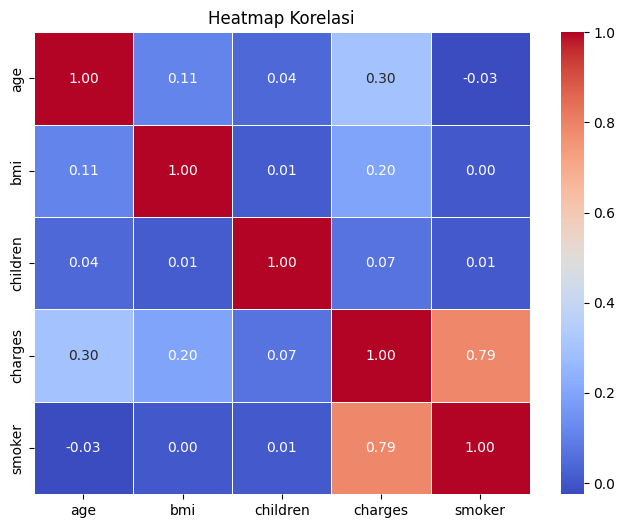

In [32]:
korelasi = df_new[['age', 'bmi', 'children', 'charges', 'smoker']]
# Menghitung korelasi
correlation = korelasi.corr()
correlation

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Heatmap Korelasi')
plt.show()

### Uji Normalitas


Kolom: age
KS Statistic = 0.0790, p-value = 0.0000
➡ Data tidak berdistribusi normal (tolak H0).


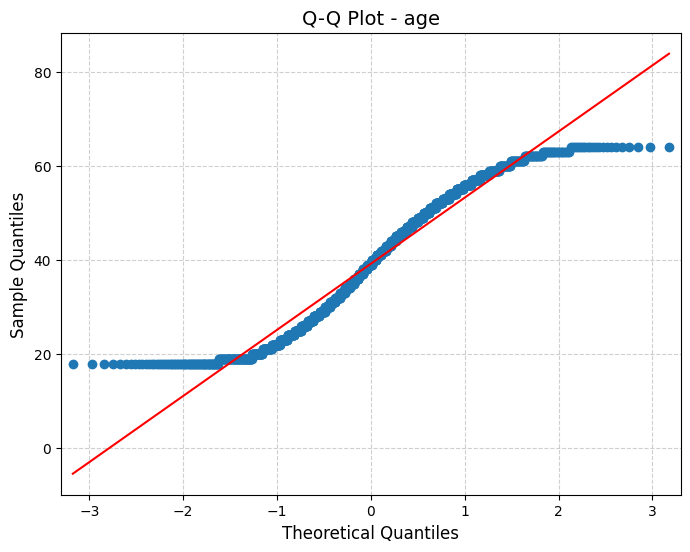


Kolom: bmi
KS Statistic = 0.0261, p-value = 0.3145
➡ Data berdistribusi normal (gagal tolak H0).


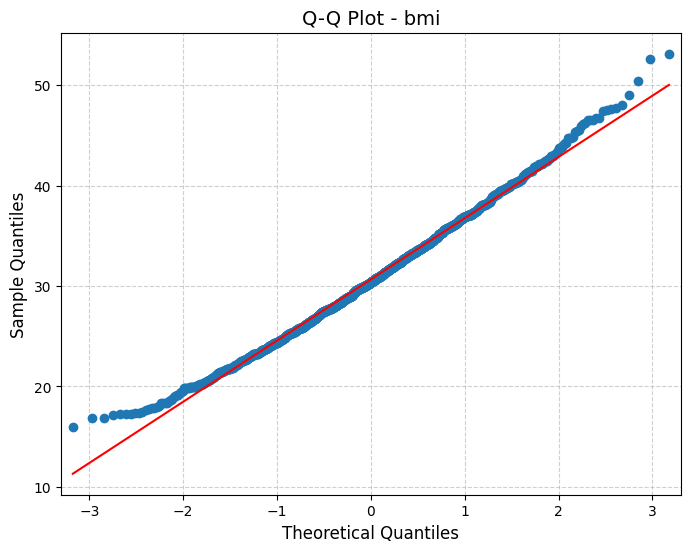


Kolom: charges
KS Statistic = 0.1885, p-value = 0.0000
➡ Data tidak berdistribusi normal (tolak H0).


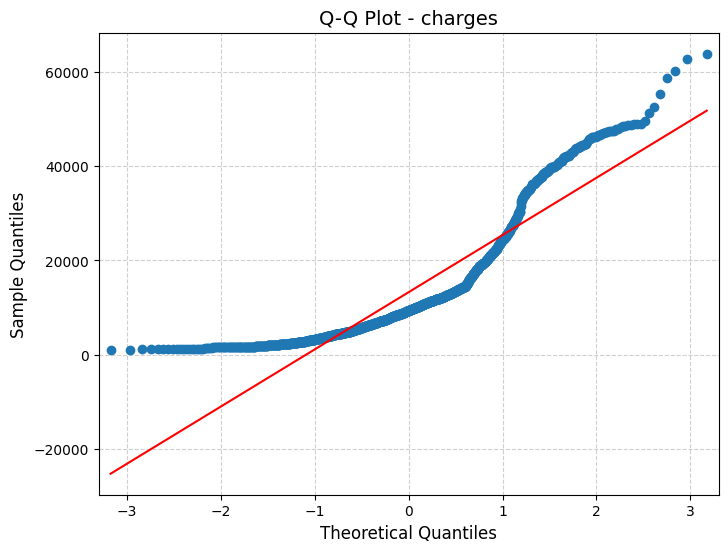

In [33]:
# Kolom numerik yang mau diuji
num_cols = ["age", "bmi", "charges"]

for col in num_cols:
    data = df[col].dropna()  # pastikan tidak ada NaN
    
    # --- Uji KS ---
    mu, sigma = np.mean(data), np.std(data)
    ks_stat, ks_p = kstest(data, 'norm', args=(mu, sigma))
    
    print(f"\nKolom: {col}")
    print(f"KS Statistic = {ks_stat:.4f}, p-value = {ks_p:.4f}")
    if ks_p > 0.05:
        print("➡ Data berdistribusi normal (gagal tolak H0).")
    else:
        print("➡ Data tidak berdistribusi normal (tolak H0).")
    
    # --- Q-Q plot (dengan ukuran lebih besar) ---
    plt.figure(figsize=(8, 6))   # ukuran lebih besar
    sm.qqplot(data, line='s', ax=plt.gca())
    plt.title(f"Q-Q Plot - {col}", fontsize=14)
    plt.xlabel("Theoretical Quantiles", fontsize=12)
    plt.ylabel("Sample Quantiles", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


### Uji Heteroskedasitas

c:\Users\72535\Downloads\latihan\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


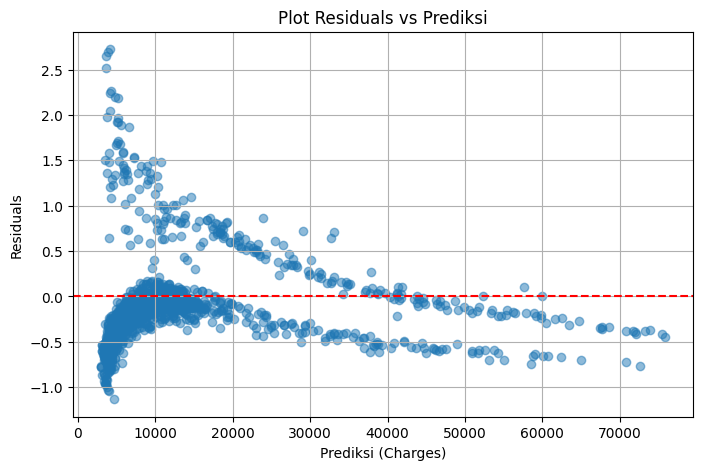

Uji Breusch-Pagan:
LM Statistic: 104.4443
LM-Test p-value: 0.0000
F Statistic: 14.0657
F-Test p-value: 0.0000
Kesimpulan: Terdapat bukti heteroskedastisitas (p-value < 0.05).


In [34]:
model = smf.glm(
    formula="charges ~ age + bmi + smoker + children + sex + region",
    data=df,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

# --- Plot Residuals ---
plt.figure(figsize=(8, 5))
plt.scatter(model.predict(), model.resid_deviance, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Plot Residuals vs Prediksi")
plt.xlabel("Prediksi (Charges)")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# --- Uji Breusch-Pagan ---
bp_test = het_breuschpagan(model.resid_deviance, model.model.exog)
bp_test_results = dict(zip(['LM Statistic', 'LM-Test p-value', 'F Statistic', 'F-Test p-value'], bp_test))

print("Uji Breusch-Pagan:")
for key, value in bp_test_results.items():
    print(f"{key}: {value:.4f}")

# Kesimpulan dari Uji Breusch-Pagan
if bp_test_results['LM-Test p-value'] < 0.05:
    print("Kesimpulan: Terdapat bukti heteroskedastisitas (p-value < 0.05).")
else:
    print("Kesimpulan: Tidak terdapat bukti heteroskedastisitas (p-value >= 0.05).")

### Cek Distribusi Data

Kolom numerik: Index(['age', 'bmi', 'children', 'charges'], dtype='object')


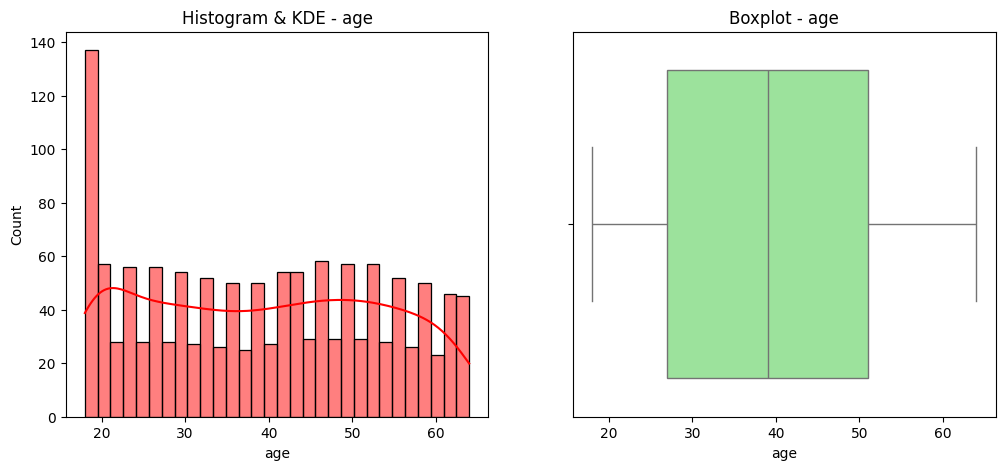

age → Skewness: 0.06, Kurtosis: -1.24


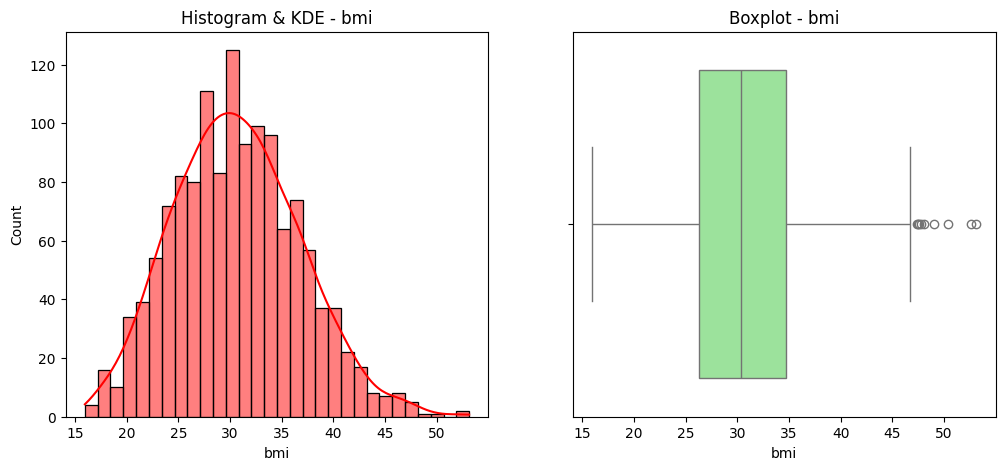

bmi → Skewness: 0.28, Kurtosis: -0.06


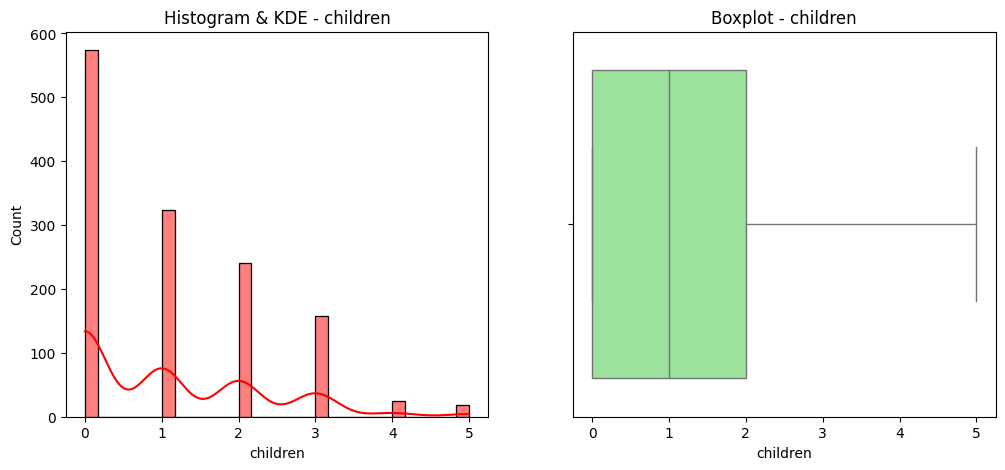

children → Skewness: 0.94, Kurtosis: 0.20


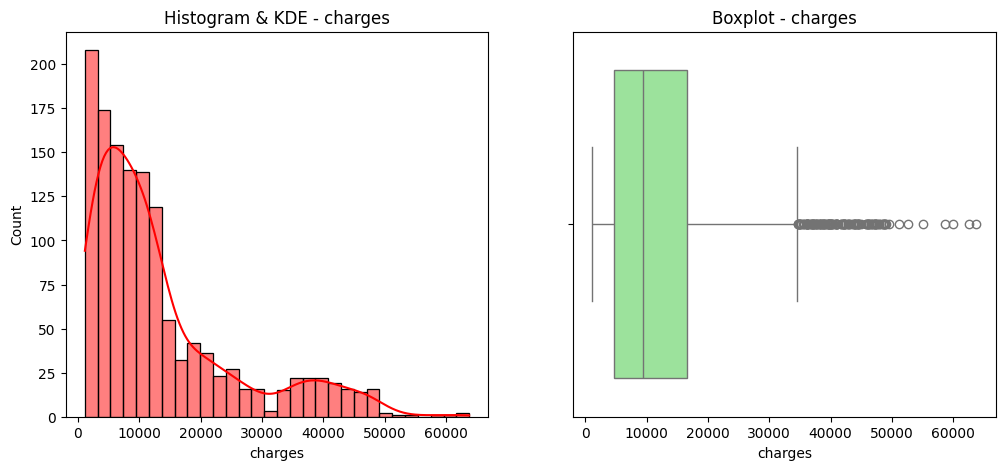

charges → Skewness: 1.51, Kurtosis: 1.60


In [35]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Kolom numerik:", numerical_cols)

for col in numerical_cols:
    plt.figure(figsize=(12,5))

    # Histogram + KDE
    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True, bins=30, color="red")
    plt.title(f"Histogram & KDE - {col}")

    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col], color="lightgreen")
    plt.title(f"Boxplot - {col}")

    plt.show()

    # Skewness & Kurtosis
    print(f"{col} → Skewness: {skew(df[col]):.2f}, Kurtosis: {kurtosis(df[col]):.2f}")


### PDF vs CDF variabel Charges

Shape: 1.4104, Loc: 0.0000, Scale: 9408.6918


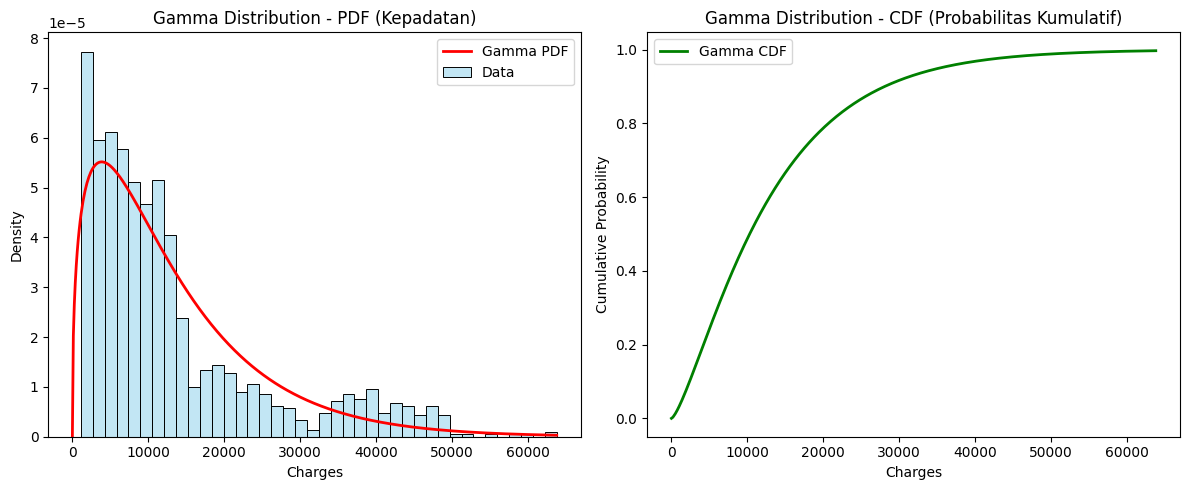

In [36]:
data = df["charges"].values

# Fit distribusi Gamma ke data
params = gamma.fit(data, floc=0)  # paksa loc=0 karena charges ≥ 0
shape, loc, scale = params
print(f"Shape: {shape:.4f}, Loc: {loc:.4f}, Scale: {scale:.4f}")

# Buat rentang nilai untuk plot
x = np.linspace(0, data.max(), 500)

# PDF dan CDF
pdf = gamma.pdf(x, shape, loc=loc, scale=scale)
cdf = gamma.cdf(x, shape, loc=loc, scale=scale)

# Plot PDF
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(data, bins=40, stat="density", color="skyblue", alpha=0.5, label="Data")
plt.plot(x, pdf, "r-", lw=2, label="Gamma PDF")
plt.title("Gamma Distribution - PDF (Kepadatan)")
plt.xlabel("Charges")
plt.ylabel("Density")
plt.legend()

# Plot CDF
plt.subplot(1,2,2)
plt.plot(x, cdf, "g-", lw=2, label="Gamma CDF")
plt.title("Gamma Distribution - CDF (Probabilitas Kumulatif)")
plt.xlabel("Charges")
plt.ylabel("Cumulative Probability")
plt.legend()

plt.tight_layout()
plt.show()


### Model Regresi

                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:                  936
Model:                            GLM   Df Residuals:                      927
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.46874
Method:                          IRLS   Log-Likelihood:                -9325.8
Date:                Mon, 29 Sep 2025   Deviance:                       241.83
Time:                        08:17:55   Pearson chi2:                     435.
No. Iterations:                    19   Pseudo R-squ. (CS):             0.6748
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.4034    

c:\Users\72535\Downloads\latihan\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


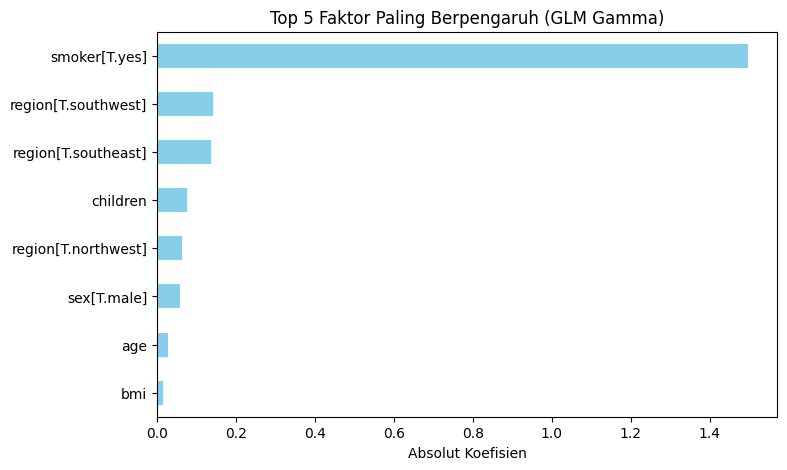


=== Persamaan Model (Log-Link, hanya variabel signifikan p < 0.05) ===
log(E[charges]) = 7.4034 + 1.4963*smoker[T.yes] + -0.1358*region[T.southeast] + -0.1415*region[T.southwest] + 0.0285*age + 0.0142*bmi + 0.0758*children

=== Bentuk Eksponensial (hanya variabel signifikan) ===
E[charges] = exp(log(E[charges]))


In [37]:
# --- Split data 70:30 ---
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# --- GLM Gamma (link log) ---
model = smf.glm(
    formula="charges ~ age + bmi + smoker + children + sex + region",
    data=train_df,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

print(model.summary())

# --- Prediksi di test set ---
y_true = test_df["charges"]
y_pred = model.predict(test_df)

# --- Evaluasi ---
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\nEvaluasi pada Test Set:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# --- Plot top 5 faktor berpengaruh ---
coef = model.params.drop("Intercept")
coef_abs = coef.abs().sort_values(ascending=False)

plt.figure(figsize=(8,5))
coef_abs.plot(kind="barh", color="skyblue")
plt.title("Top 5 Faktor Paling Berpengaruh (GLM Gamma)")
plt.xlabel("Absolut Koefisien")
plt.gca().invert_yaxis()
plt.show()

# --- Cetak Persamaan Model (hanya p < 0.05) ---
print("\n=== Persamaan Model (Log-Link, hanya variabel signifikan p < 0.05) ===")

params = model.params
pvals = model.pvalues

# filter hanya variabel signifikan
significant_vars = [var for var in params.index if (var != "Intercept") and (pvals[var] < 0.05)]

if significant_vars:
    eq_terms = " + ".join([f"{params[var]:.4f}*{var}" for var in significant_vars])
    print(f"log(E[charges]) = {params['Intercept']:.4f} + {eq_terms}")

    print("\n=== Bentuk Eksponensial (hanya variabel signifikan) ===")
    print("E[charges] = exp(log(E[charges]))")
else:
    print("Tidak ada variabel signifikan dengan p < 0.05")

### Klasifikasi dan Evaluasi

charges_bin
Low       446
Medium    446
High      446
Name: count, dtype: int64


Jumlah data pelatihan: 936
Jumlah data pengujian: 402
Shape data pelatihan: (936, 6)
Shape data pengujian: (402, 6)


=== Logistic Regression (class_weight='balanced') ===
              precision    recall  f1-score   support

        High     1.0000    0.6269    0.7706       134
         Low     0.9023    0.8955    0.8989       134
      Medium     0.7081    0.9776    0.8213       134

    accuracy                         0.8333       402
   macro avg     0.8701    0.8333    0.8303       402
weighted avg     0.8701    0.8333    0.8303       402


Confusion Matrix (LogReg):
        Low  Medium  High
Low     120      14     0
Medium    3     131     0
High     10      40    84


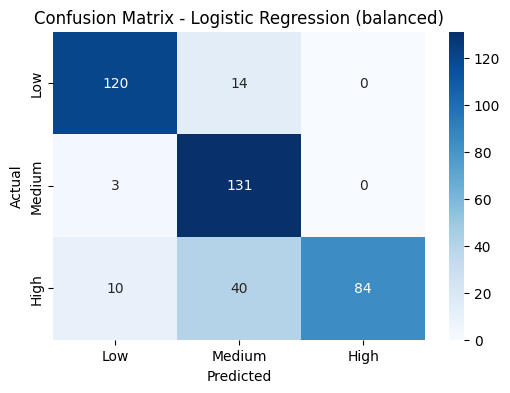

In [38]:

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- 1. Binning: quantile (equal-frequency) into 3 classes: Low, Medium, High ---
df['charges_bin'] = pd.qcut(df['charges'], q=3, labels=['Low', 'Medium', 'High'])

# --- 2. Features and target ---
features = ['age', 'bmi', 'children', 'smoker', 'sex', 'region']
X = df[features]
y = df['charges_bin']
print(y.value_counts())
print("\n")

# --- 3. Train-test split (stratify to keep class proportions) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Menampilkan jumlah data
print("Jumlah data pelatihan:", len(X_train))
print("Jumlah data pengujian:", len(X_test))

# Atau menggunakan .shape untuk mendapatkan lebih banyak informasi
print("Shape data pelatihan:", X_train.shape)
print("Shape data pengujian:", X_test.shape)
print("\n")

# --- 4. Preprocessing ---
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['smoker', 'sex', 'region']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# --- 5. Pipelines: Logistic Regression (balanced) and Random Forest (balanced) ---
lr_pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
])


# --- 6. Train and evaluate Logistic Regression ---
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("=== Logistic Regression (class_weight='balanced') ===")
print(classification_report(y_test, y_pred_lr, digits=4))

cm_lr = confusion_matrix(y_test, y_pred_lr, labels=['Low','Medium','High'])
cm_lr_df = pd.DataFrame(cm_lr, index=['Low','Medium','High'], columns=['Low','Medium','High'])
print("\nConfusion Matrix (LogReg):")
print(cm_lr_df)

plt.figure(figsize=(6,4))
sns.heatmap(cm_lr_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression (balanced)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()